In [4]:
from preprocess import *
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
import sklearn
from imblearn.over_sampling import RandomOverSampler

In [5]:
# path of dataset
data_path = "./data/Trigger Word Detection Dataset/Training Dataset/"
data_arrays_path = "./data_arrays/Trigger Word Detection Dataset/Training Dataset/"

# assigning parameters for MFCC feature extraction
max_len_nfft = 682
n_mfcc = 128

In [3]:
# Saving data to array file
save_data_to_array(data_path=data_path, data_arrays_path=data_arrays_path, max_len=max_len_nfft, n_mfcc=n_mfcc)

Saving vectors of label - 'Ruha': 100%|████████████████████████████████████████████| 6571/6571 [06:47<00:00, 16.13it/s]


In [3]:
# Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test(data_path=data_path, data_arrays_path=data_arrays_path, split_ratio=0.8)
print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (6544, 128, 682)
X_test:  (1636, 128, 682)


In [4]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# reshaping the data for oversampling
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

# fit and apply the transform
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_test, y_test = oversample.fit_resample(X_test, y_test)

# converting it back to original shape
X_train = X_train.reshape(X_train.shape[0], n_mfcc, max_len_nfft)
X_test = X_test.reshape(X_test.shape[0], n_mfcc, max_len_nfft)

print("X_train: ", X_train.shape, end='\t')
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape, end='\t')
print("y_test: ", y_test.shape)

X_train:  (10550, 128, 682)	y_train:  (10550,)
X_test:  (2592, 128, 682)	y_test:  (2592,)


1.0


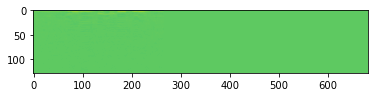

In [5]:
plt.imshow(X_train[100, :, :])
print(y_train[100])

In [6]:
# Feature dimension
epochs = 50
batch_size = 128
num_classes = 2

# model
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, input_shape=(n_mfcc, max_len_nfft, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 681, 16)      80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 340, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 340, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 339, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 169, 32)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 31, 169, 32)       0

In [7]:
# adding loss and optimizer
model.compile(loss="SparseCategoricalCrossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [8]:
# training the model
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=True)

Epoch 1/50
83/83 [==============================] - 271s 3s/step - loss: 0.6975 - accuracy: 0.5413 - val_loss: 0.6585 - val_accuracy: 0.6617
Epoch 2/50
83/83 [==============================] - 273s 3s/step - loss: 0.5934 - accuracy: 0.7127 - val_loss: 0.5418 - val_accuracy: 0.7828
Epoch 3/50
83/83 [==============================] - 272s 3s/step - loss: 0.5164 - accuracy: 0.7699 - val_loss: 0.4905 - val_accuracy: 0.7843
Epoch 4/50
83/83 [==============================] - 272s 3s/step - loss: 0.4605 - accuracy: 0.7898 - val_loss: 0.4487 - val_accuracy: 0.7955
Epoch 5/50
83/83 [==============================] - 295s 4s/step - loss: 0.4181 - accuracy: 0.8100 - val_loss: 0.3930 - val_accuracy: 0.8329
Epoch 6/50
83/83 [==============================] - 272s 3s/step - loss: 0.4005 - accuracy: 0.8197 - val_loss: 0.3819 - val_accuracy: 0.8372
Epoch 7/50
83/83 [==============================] - 273s 3s/step - loss: 0.3919 - accuracy: 0.8245 - val_loss: 0.3941 - val_accuracy: 0.8306
Epoch 8/50
83

In [9]:
model.save("./Models/Trigger Word Detection Model")

INFO:tensorflow:Assets written to: ./Models/Trigger Word Detection Model\assets
